# Validation and MC Studies

## RooFit tutorial macro #801

A Toy Monte Carlo study that performs cycles of event generation and fitting.

---

In [1]:
using namespace RooFit;

## Create model
Declare observable x.

In [2]:
RooRealVar x("x","x",0,10);
x.setBins(40);


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Create two Gaussian PDFs `g1(x,mean1,sigma)` and `g2(x,mean2,sigma)` and their parameters.

In [3]:
RooRealVar mean("mean","mean of gaussians",5,0,10);
RooRealVar sigma1("sigma1","width of gaussians",0.5);
RooRealVar sigma2("sigma2","width of gaussians",1);

RooGaussian sig1("sig1","Signal component 1",x,mean,sigma1);
RooGaussian sig2("sig2","Signal component 2",x,mean,sigma2);

Build Chebychev polynomial p.d.f.

In [4]:
RooRealVar a0("a0","a0",0.5,0.,1.);
RooRealVar a1("a1","a1",-0.2,-1,1.);
RooChebychev bkg("bkg","Background",x,RooArgSet(a0,a1));

Sum the signal components into a composite signal p.d.f.

In [5]:
RooRealVar sig1frac("sig1frac","fraction of component 1 in signal",0.8,0.,1.);
RooAddPdf sig("sig","Signal",RooArgList(sig1,sig2),sig1frac);

Sum the composite signal and background.

In [6]:
RooRealVar nbkg("nbkg","number of background events,",150,0,1000);
RooRealVar nsig("nsig","number of signal events",150,0,1000);
RooAddPdf  model("model","g1+g2+a",RooArgList(bkg,sig),RooArgList(nbkg,nsig));

## Create manager
Instantiate RooMCStudy manager on model with x as observable and given choice of fit options.

The `Silence()` option kills all messages below the `PROGRESS` level, leaving only a single message per sample executed, and any error message that occurred during fitting.

The `Extended()` option has two effects: 
1. The extended ML term is included in the likelihood.
2. A poisson fluctuation is introduced on the number of generated events. 

The `FitOptions()` given here are passed to the fitting stage of each toy experiment. If `Save()` is specified, the fit result of each experiment is saved by the manager.

A `Binned()` option is added in this example to bin the data between generation and fitting to speed up the study at the expense of some precision.

In [7]:
RooMCStudy mcstudy(model,
                   x,
                   Binned(kTRUE),
                   Silence(),
                   Extended(),
                   FitOptions(Save(kTRUE),PrintEvalErrors(0)));

## Generate and fit events
Generate and fit 1000 samples of `Poisson(nExpected)` events.

In [8]:
mcstudy.generateAndFit(1000);

[#0] PROGRESS:Generation -- RooMCStudy::run: sample 990
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 980
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 970
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 960
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 950
[#0] WARNING:Minization -- RooMinuitGlue: Minimized function has error status.
Returning maximum FCN so far (-797.721) to force MIGRAD to back out of this region. Error log follows
Parameter values: a0=0.716236, a1=-0.675686, mean=5.04367, nbkg=115.661, nsig=155.327, sig1frac=0.880121
RooChebychev::bkg[ x=x coefList=(a0,a1) ] has 1 errors

[#0] PROGRESS:Generation -- RooMCStudy::run: sample 940
[#0] PROGRESS:Generation -- RooMCStudy::run: sample 930
[#0] WARNING:Minization -- RooMinuitGlue: Minimized function has error status.
Returning maximum FCN so far (-867.289) to force MIGRAD to back out of this region. Error log follows
Parameter values: a0=0.907715, a1=-0.26012, mean=4.95881, nbkg=147.451, nsig=156.366,

## Explore results of study
Make plots of the distributions of the mean, the error of the mean and the pull of the mean.

In [9]:
auto frame1 = mcstudy.plotParam(mean,Bins(64));
auto frame2 = mcstudy.plotError(mean,Bins(64));
auto frame3 = mcstudy.plotPull(mean,Bins(64),FitGauss(kTRUE));


[#1] INFO:NumericIntegration -- RooRealIntegral::init(pullGauss_Int[meanpull]) using numeric integrator RooIntegrator1D to calculate Int(meanpull)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(pullGauss_Int[meanpull]) using numeric integrator RooIntegrator1D to calculate Int(meanpull)


Plot distribution of minimized likelihood.

In [10]:
auto frame4 = mcstudy.plotNLL(Bins(64));

Create some histograms from the parameter dataset.

In [11]:
auto hh_cor_a0_s1f = mcstudy.fitParDataSet().createHistogram("hh",a1,YVar(sig1frac));
auto hh_cor_a0_a1  = mcstudy.fitParDataSet().createHistogram("hh",a0,YVar(a1));

Access some of the saved fit results from individual toys.

In [12]:
auto corrHist000 = mcstudy.fitResult(0)->correlationHist("c000");
auto corrHist127 = mcstudy.fitResult(127)->correlationHist("c127");
auto corrHist953 = mcstudy.fitResult(953)->correlationHist("c953");

Draw all plots on a canvas.

In [13]:
gStyle->SetPalette(1);
gStyle->SetOptStat(0);
TCanvas c("rf801_mcstudy","rf801_mcstudy",900,900);
c.Divide(3,3);
c.cd(1); gPad->SetLeftMargin(0.15); frame1->GetYaxis()->SetTitleOffset(1.4); frame1->Draw();
c.cd(2); gPad->SetLeftMargin(0.15); frame2->GetYaxis()->SetTitleOffset(1.4); frame2->Draw();
c.cd(3); gPad->SetLeftMargin(0.15); frame3->GetYaxis()->SetTitleOffset(1.4); frame3->Draw();
c.cd(4); gPad->SetLeftMargin(0.15); frame4->GetYaxis()->SetTitleOffset(1.4); frame4->Draw();
c.cd(5); gPad->SetLeftMargin(0.15); hh_cor_a0_s1f->GetYaxis()->SetTitleOffset(1.4); hh_cor_a0_s1f->Draw("box");
c.cd(6); gPad->SetLeftMargin(0.15); hh_cor_a0_a1->GetYaxis()->SetTitleOffset(1.4); hh_cor_a0_a1->Draw("box");
c.cd(7); gPad->SetLeftMargin(0.15); corrHist000->GetYaxis()->SetTitleOffset(1.4); corrHist000->Draw("colz");
c.cd(8); gPad->SetLeftMargin(0.15); corrHist127->GetYaxis()->SetTitleOffset(1.4); corrHist127->Draw("colz");
c.cd(9); gPad->SetLeftMargin(0.15); corrHist953->GetYaxis()->SetTitleOffset(1.4); corrHist953->Draw("colz");

Draw the canvas.

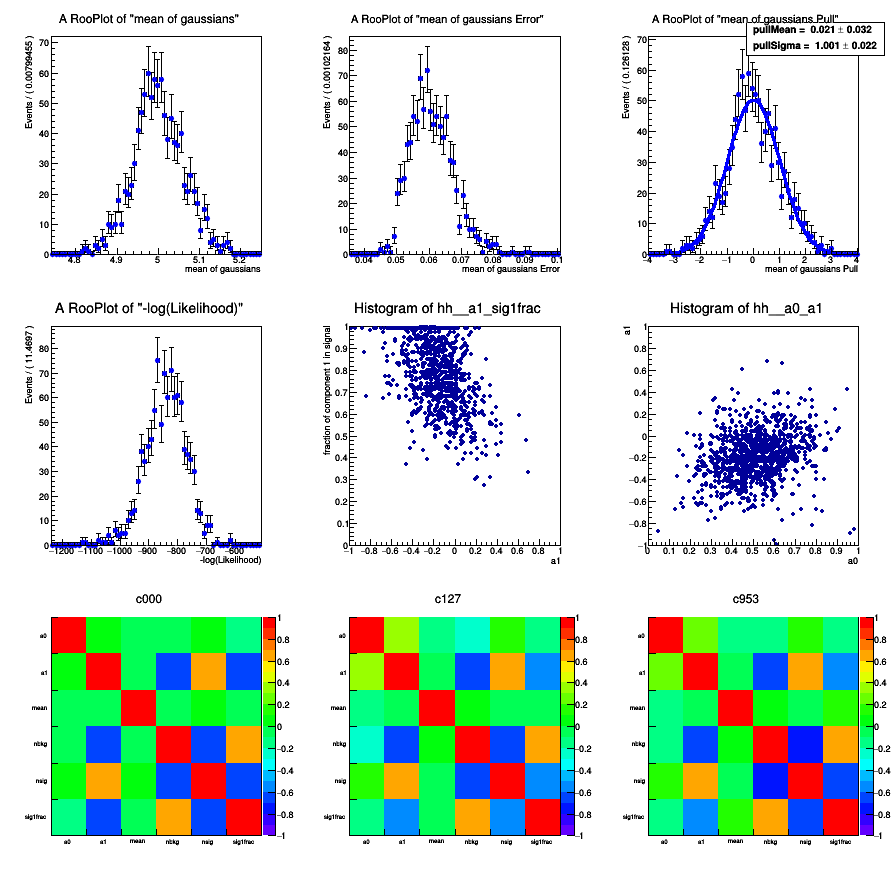

In [14]:
c.Draw();